# Stock Price Forecasting Using SVR

This notebook performs time-series forecasting on GOOGL stock using SVR. The process includes data collection, preprocessing, EDA, model training, and evaluation.

## Step 1: Data Collection and Preprocessing

### 1.1 Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### 1.2 Download GOOGL Stock Data

In this step, the code downloads daily stock data for GOOGL (Google/Alphabet) from Yahoo Finance covering the period 2010-01-01 to 2021-05-31. Both the raw Close price and Adjusted Close price are extracted.

In [2]:
df = yf.download("GOOGL",
                 start="2010-01-01", end="2021-05-31",
                 auto_adjust=False, group_by="column", progress=False).reset_index()
print(df[['Date','Close','Adj Close']].head())


Price        Date      Close  Adj Close
Ticker                 GOOGL      GOOGL
0      2010-01-04  15.684434  15.590930
1      2010-01-05  15.615365  15.522273
2      2010-01-06  15.221722  15.130976
3      2010-01-07  14.867367  14.778734
4      2010-01-08  15.065566  14.975752


### Feature Engineering and Target Creation

The dataset is enriched with new features: log-transformed trading volume, day of week, and day of year to capture trading patterns and seasonality. The target is set as the next-day closing price by shifting the Close column. After removing missing values from this shift, 2,870 rows remain for modeling.

In [3]:

if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

df['Date'] = pd.to_datetime(df['Date'])


df['log_volume']  = np.log(df['Volume'] + 1e-8)
df['day_of_week'] = df['Date'].dt.dayofweek   
df['day_of_year'] = df['Date'].dt.dayofyear   


df['Target'] = df['Close'].shift(-1)


df['Close_raw'] = df['Close']


df = df.dropna(subset=['Target']).reset_index(drop=True)

print("Rows after target-only drop:", len(df))
df[['Date','Close_raw','Close','Target']].head()


Rows after target-only drop: 2870


,Date,Close_raw,Close,Target
0,2010-01-04,15.684434,15.684434,15.615365
1,2010-01-05,15.615365,15.615365,15.221722
2,2010-01-06,15.221722,15.221722,14.867367
3,2010-01-07,14.867367,14.867367,15.065566
4,2010-01-08,15.065566,15.065566,15.042793


### Data Scaling

All input features (Close, High, Low, log_volume, day_of_week, day_of_year) and the target are scaled separately using MinMaxScaler. This ensures that values lie between 0 and 1, improving SVR performance. No missing values were found, and 2,870 rows remain after scaling.

In [4]:

feature_cols   = ['Close', 'High', 'Low', 'log_volume', 'day_of_week', 'day_of_year']
feature_scaler = MinMaxScaler()
target_scaler  = MinMaxScaler()

# Sanity check
print("NaNs before scaling:\n", df[feature_cols + ['Target']].isna().sum())


df[feature_cols]    = feature_scaler.fit_transform(df[feature_cols])
df['Target_scaled'] = target_scaler.fit_transform(df[['Target']])

print("Rows after scaling:", len(df))
df[['Date','Close_raw','Close','Target','Target_scaled']].head()


NaNs before scaling:
 Close          0
High           0
Low            0
log_volume     0
day_of_week    0
day_of_year    0
Target         0
dtype: int64
Rows after scaling: 2870


,Date,Close_raw,Close,Target,Target_scaled
0,2010-01-04,15.684434,0.043888,15.615365,0.043253
1,2010-01-05,15.615365,0.043253,15.221722,0.039633
2,2010-01-06,15.221722,0.039633,14.867367,0.036373
3,2010-01-07,14.867367,0.036373,15.065566,0.038196
4,2010-01-08,15.065566,0.038196,15.042793,0.037987


## Sliding Window Visualization

This figure shows the 5-day sliding window used for SVR input. The blue markers highlight the past 5 days of closing prices, and the red marker marks the next day's closing price — the prediction target. The left panel displays the window in the context of the full price series, and the right panel zooms in to focus on the input and target days.

In [5]:
def plot_sliding_window_side_by_side_svr(df, start_idx, window_size, title):
    """
    Visualize SVR input window (t-window_size...t-1) and next-day target (t).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(df["Date"], df["Close"], color="gray", alpha=0.6, label="Close Price")
    input_dates = df["Date"].iloc[start_idx:start_idx+window_size]
    input_prices = df["Close"].iloc[start_idx:start_idx+window_size]
    axes[0].plot(input_dates, input_prices, color="blue", linewidth=2, marker="o", label=f"Input Window ({window_size} days)")
    pred_date = df["Date"].iloc[start_idx+window_size]
    pred_price = df["Close"].iloc[start_idx+window_size]
    axes[0].scatter(pred_date, pred_price, color="red", s=100, zorder=5, label="Prediction Target")
    axes[0].set_title(f"{title} (Full Series)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close Price (USD)")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.5)

    axes[1].plot(df["Date"], df["Close"], color="gray", alpha=0.6, label="Close Price")
    axes[1].plot(input_dates, input_prices, color="blue", linewidth=2, marker="o", label=f"Input Window ({window_size} days)")
    axes[1].scatter(pred_date, pred_price, color="red", s=100, zorder=5, label="Prediction Target")
    start = start_idx - 5 if start_idx - 5 > 0 else 0
    end = start_idx + window_size + 5
    axes[1].set_xlim(df["Date"].iloc[start], df["Date"].iloc[end])
    axes[1].set_title(f"{title} (Zoomed-In)")
    axes[1].set_xlabel("Date")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()
    


## Step 2: Exploratory Data Analysis (EDA)

### 2.1 Price Trend (split-adjusted USD vs normalised)

In this step, I plot Google’s closing price in both split-adjusted USD and normalised (0–1) form. The USD view shows the absolute price path, while the normalised view highlights relative fluctuations and provides the scale used for model training. The upper panel shows long-term growth with periods of volatility (e.g., the 2020 drawdown and rebound). The lower panel removes magnitude effects, isolating relative movements. This supports the choice of a 5-day input window and Close-only SVR, while reminding us that volatility spikes make predictions harder.

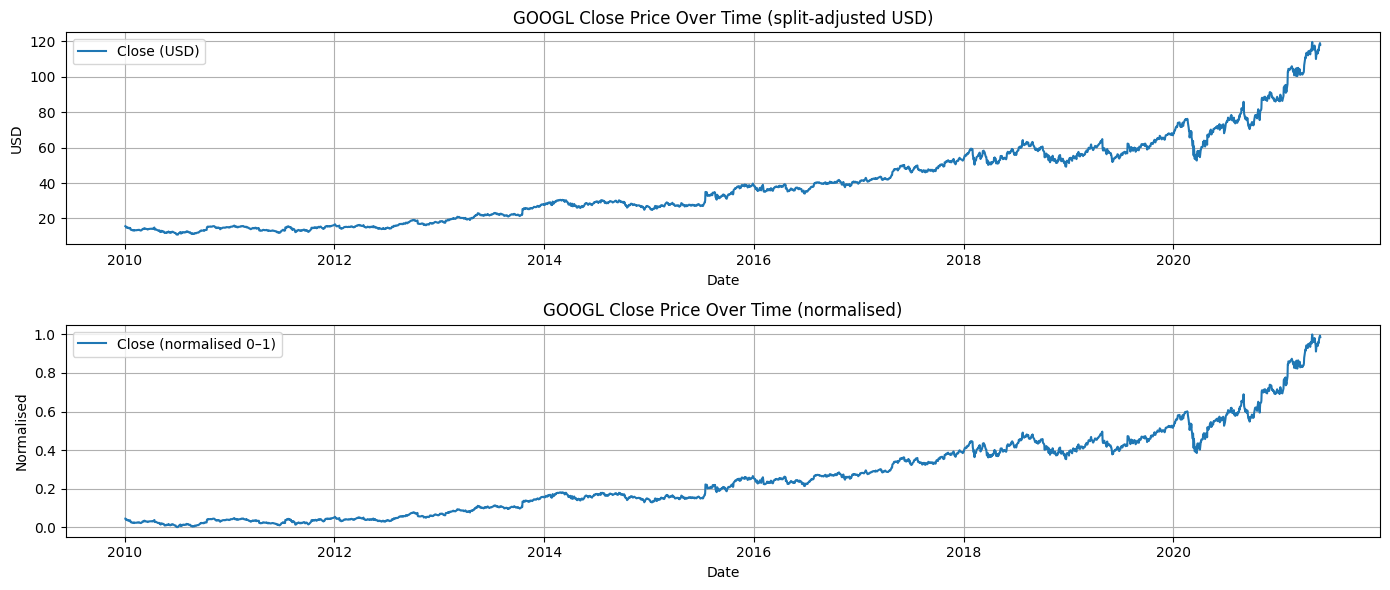

In [6]:
plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(df['Date'], df['Close_raw'], label='Close (USD)')
plt.title('GOOGL Close Price Over Time (split-adjusted USD)')
plt.xlabel('Date'); plt.ylabel('USD'); plt.grid(True); plt.legend()

plt.subplot(2,1,2)
plt.plot(df['Date'], df['Close'], label='Close (normalised 0–1)')
plt.title('GOOGL Close Price Over Time (normalised)')
plt.xlabel('Date'); plt.ylabel('Normalised'); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


### 2.2 Target Distribution (next-day Close): USD vs normalised

The left plot shows the next-day closing price in split-adjusted USD, which is skewed to the right with most values clustered in the lower range and a smaller number of higher prices as the stock grew over time. The right plot shows the same distribution scaled to a 0–1 range. Scaling keeps the overall shape but removes the units, which is useful for training the SVR since features and targets are then on the same scale. The skew means the model will see many more examples of lower prices than higher ones, which can make the upper range harder to predict.

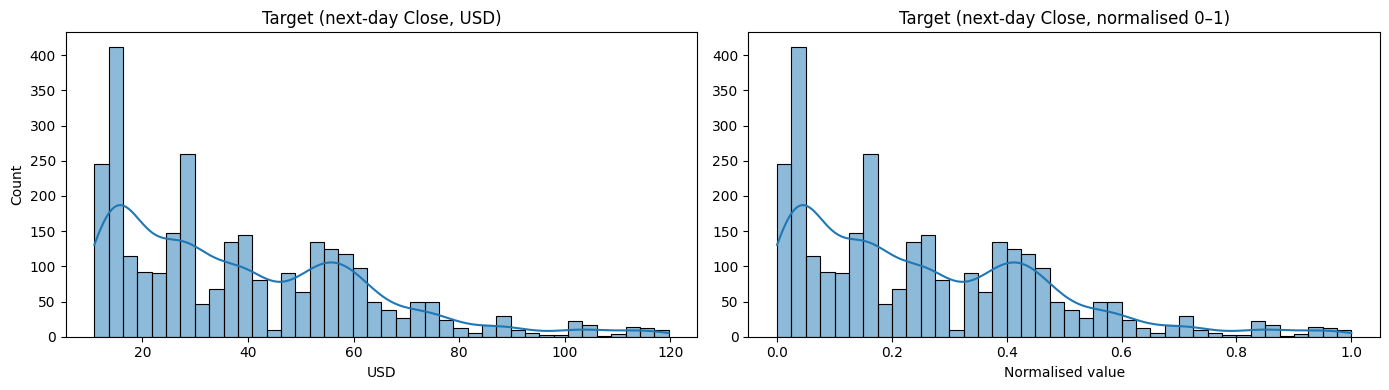

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df['Target'], bins=40, kde=True, ax=axes[0])
axes[0].set_title('Target (next-day Close, USD)')
axes[0].set_xlabel('USD')
axes[0].set_ylabel('Count')

sns.histplot(df['Target_scaled'], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Target (next-day Close, normalised 0–1)')
axes[1].set_xlabel('Normalised value')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()



### 2.3 Autocorrelation and Partial Autocorrelation Analysis



The ACF (left) shows very strong persistence, with correlations staying high across many lags, which is typical of stock price levels. The PACF (right) drops off quickly after lag 1, suggesting that most of the predictive information is captured by very recent observations. This supports the use of short input windows (such as 5 days) in the SVR, as longer lags do not add much new information once the immediate past is accounted for.

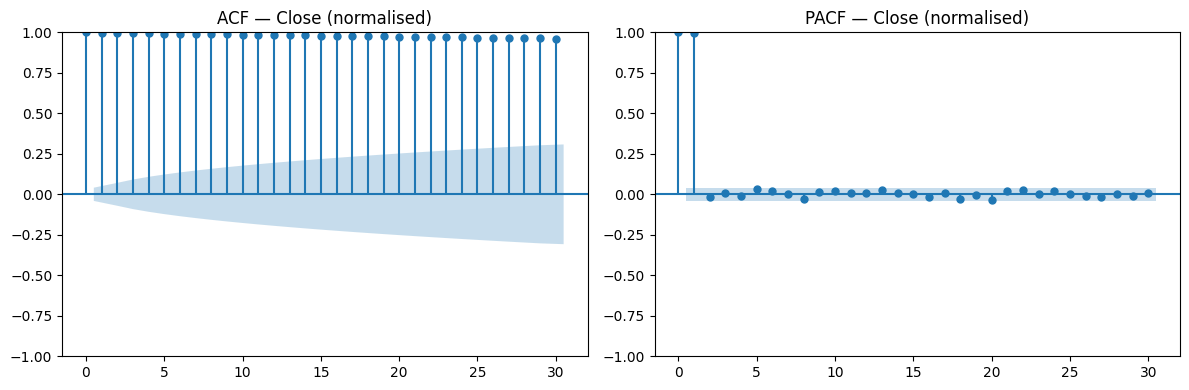

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

split = int(0.8 * len(df))
series = df['Close'].iloc[:split]  

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(series, lags=30, ax=axes[0])
axes[0].set_title('ACF — Close (normalised)')

plot_pacf(series, lags=30, method='ywm', ax=axes[1])
axes[1].set_title('PACF — Close (normalised)')

plt.tight_layout()
plt.show()


### 2.4 Moving Average and Volatility

The 20-day moving average smooths out daily noise and follows the overall trend of the stock. The shaded ±1 standard deviation band shows how volatile the price is around this trend. Narrow bands correspond to quieter, stable periods, while wider bands mark times of higher volatility, such as market drawdowns or rallies. This helps to illustrate when short-term prediction becomes harder due to sudden price swings.

Figure note: 20-day moving average and standard deviation are calculated on the normalised Close series.

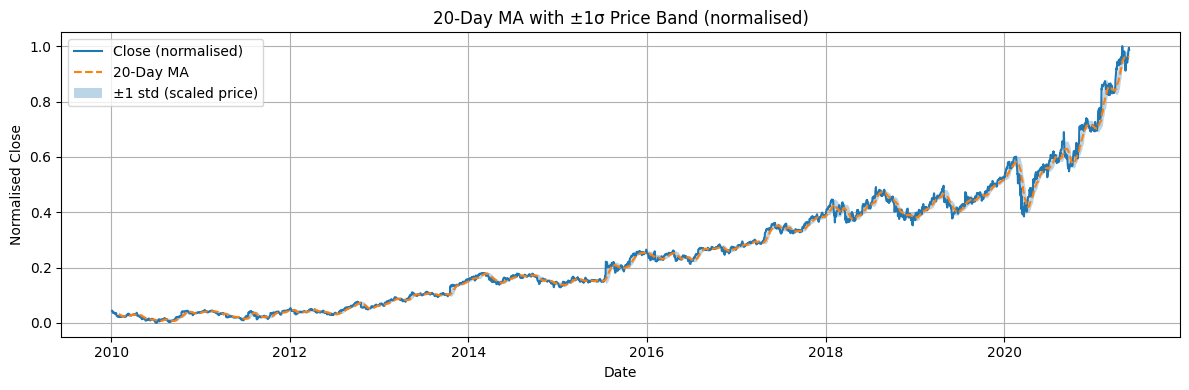

In [9]:
df['MA_20']  = df['Close'].rolling(20).mean()      
df['STD_20'] = df['Close'].rolling(20).std()

plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Close'], label='Close (normalised)')
plt.plot(df['Date'], df['MA_20'], '--', label='20-Day MA')
plt.fill_between(df['Date'], df['MA_20']-df['STD_20'], df['MA_20']+df['STD_20'],
                 alpha=0.3, label='±1 std (scaled price)')
plt.title('20-Day MA with ±1σ Price Band (normalised)')
plt.xlabel('Date'); plt.ylabel('Normalised Close'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


### 2.5 Correlation Heatmap

The heatmap shows how each feature correlates with the next-day closing price (Target). As expected, Close, High, and Low are nearly perfectly correlated with the target, which confirms redundancy among these price-based features. Log-volume has a weak negative correlation, while calendar variables such as day-of-week and day-of-year show almost no correlation. This suggests that price features dominate predictive power, whereas volume and seasonal signals add little on their own.

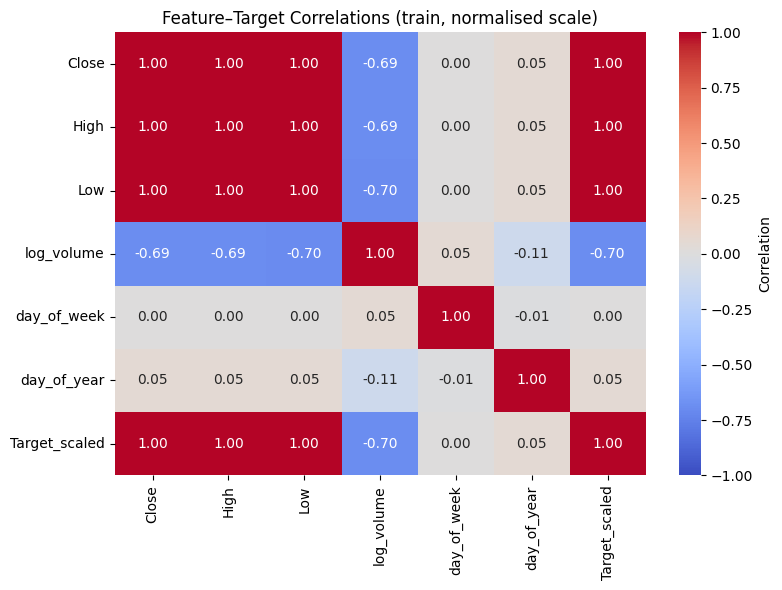

In [10]:
split = int(0.8 * len(df))
cols  = ['Close', 'High', 'Low', 'log_volume', 'day_of_week', 'day_of_year', 'Target_scaled']

corr = df.loc[:split-1, cols].corr()  

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm", fmt=".2f",
            cbar_kws={"label": "Correlation"})
plt.title("Feature–Target Correlations (train, normalised scale)")
plt.tight_layout()
plt.show()



### 2.6 Boxplots for Outlier Detection

The boxplots show the distribution of scaled price (Close, High, Low) and volume (log-volume) features. Price features are mostly symmetric, with some upper-end outliers that align with sharp rallies. Log-volume displays a wider spread and more frequent outliers, reflecting occasional surges in trading activity. These outliers are genuine market events rather than data errors, so they are retained for modelling.

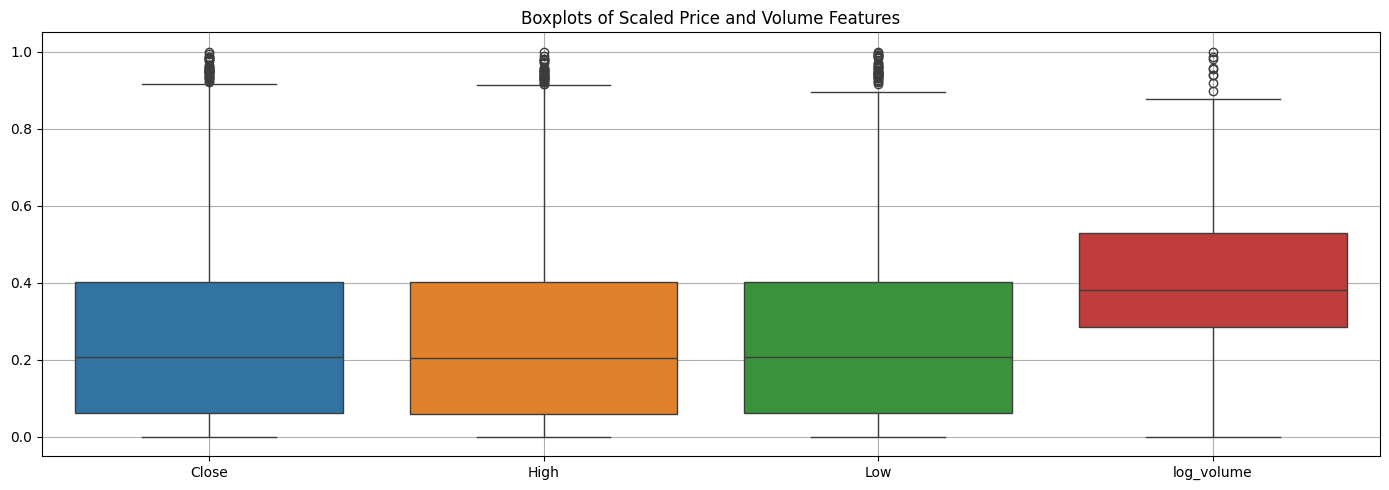

In [11]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df[['Close', 'High', 'Low', 'log_volume']])
plt.title("Boxplots of Scaled Price and Volume Features")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.7 Distribution Plots for Feature Analysis

In this section, I examined how some of the main features in the dataset are distributed. The first plot shows the distribution of the normalised closing prices, which is right-skewed. This is expected, as stock prices tend to rise over time, creating a long upper tail.

The second plot displays the log-transformed trading volume. Applying the log reduced skewness and produced a more balanced distribution, making the feature easier to work with in modelling.

The third plot is for the Target variable (next day’s closing price), and its shape closely mirrors that of the Close price, which is reasonable since it is derived from it.

Overall, these plots confirm that the data has no major imbalances. The skew in price and target suggests that most predictive information lies in short-term movements, which supports the choice of a short input window and a non-linear model such as SVR.

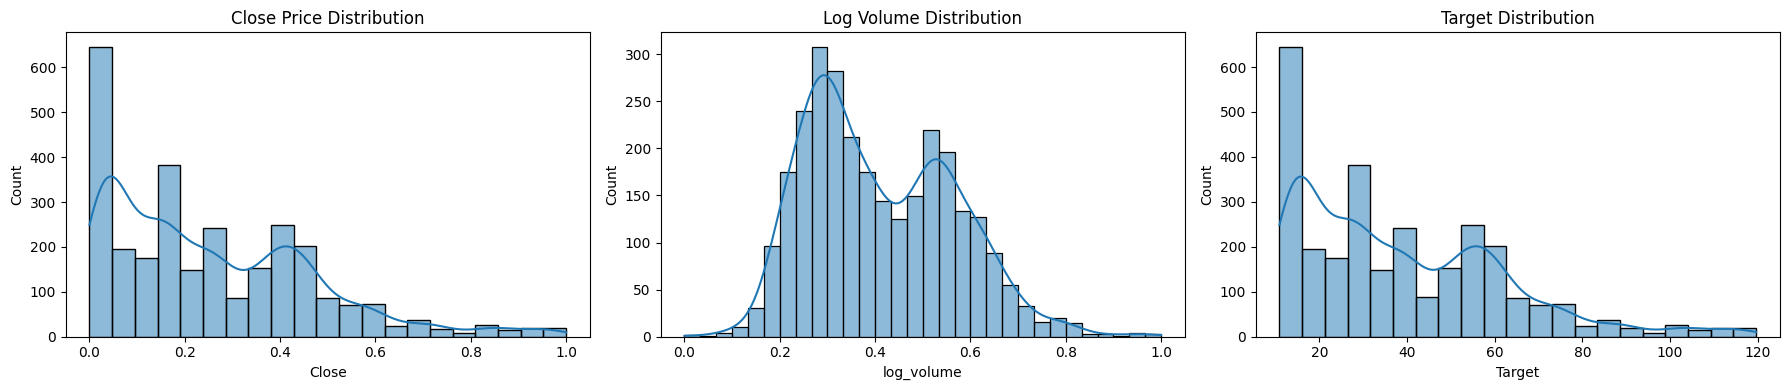

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['Close'], kde=True, ax=axes[0]).set(title='Close Price Distribution')
sns.histplot(df['log_volume'], kde=True, ax=axes[1]).set(title='Log Volume Distribution')
sns.histplot(df['Target'], kde=True, ax=axes[2]).set(title='Target Distribution')
plt.tight_layout()
plt.show()

### 2.8 Skewness and kurtosis of key features

To further assess the shape of the feature distributions, I calculated skewness and kurtosis. The Close and Target variables are moderately right-skewed, which is typical for stock prices as they trend upward. Log-transformed volume shows only mild skewness. For kurtosis, Close and Target have slightly heavier tails, while log_volume is flatter with fewer extreme values. These results are consistent with the earlier distribution plots and support the scaling and transformation steps applied.

In [13]:
print("Skewness:")
print(df[['Close', 'log_volume', 'Target']].skew())

print("\nKurtosis:")
print(df[['Close', 'log_volume', 'Target']].kurt())


Skewness:
Close         0.977986
log_volume    0.481594
Target        0.981930
dtype: float64

Kurtosis:
Close         0.629548
log_volume   -0.367721
Target        0.642607
dtype: float64


### 2.9 Time Series Decomposition

To better understand the Close price series, I performed a seasonal decomposition using a multiplicative model. The trend component shows a steady long-term upward movement in GOOGL stock prices. The seasonal component highlights repeating yearly patterns, while the residual captures short-term fluctuations not explained by trend or seasonality. This breakdown confirms that the stock has both strong trend and seasonal effects, which need to be considered in forecasting.

/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_20121/1079491262.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  googl_raw = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
[*********************100%***********************]  1 of 1 completed


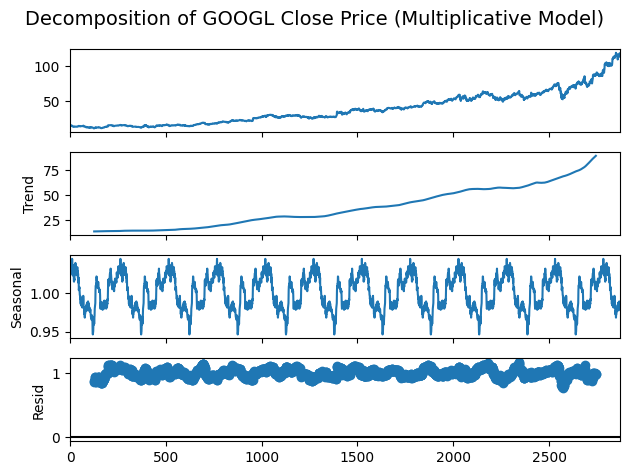

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose unscaled close values for better interpretation
googl_raw = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
googl_raw = googl_raw.reset_index()
result = seasonal_decompose(googl_raw['Close'], model='multiplicative', period=252)
result.plot()
plt.suptitle("Decomposition of GOOGL Close Price (Multiplicative Model)", fontsize=14)
plt.tight_layout()
plt.show()

### 2.10 Lag Feature Correlation

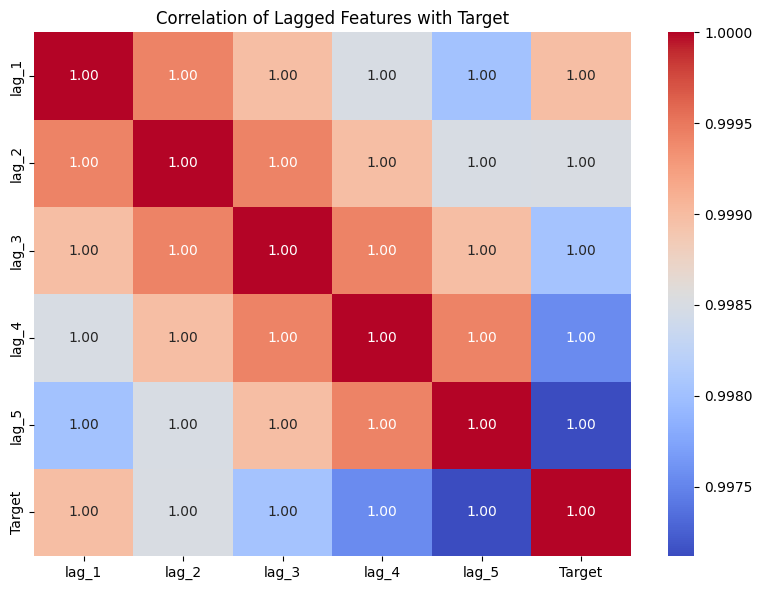

In [15]:
for lag in range(1, 6):
    df[f'lag_{lag}'] = df['Close'].shift(lag)


lagged_df = df.dropna()


plt.figure(figsize=(8, 6))
sns.heatmap(lagged_df[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'Target']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Lagged Features with Target")
plt.tight_layout()
plt.show()

To test the usefulness of lagged values, I created features for the previous five days of closing prices and compared their correlation with the next-day target. The heatmap shows very high correlations across all lags, which is expected in financial time series where today’s price is strongly related to recent past values. The correlation weakens slightly as the lag increases, but the relationship remains strong overall. This supports the use of short lag windows (like the 5-day input) in forecasting models.

## 2.11  Distributional properties of GOOGL daily series

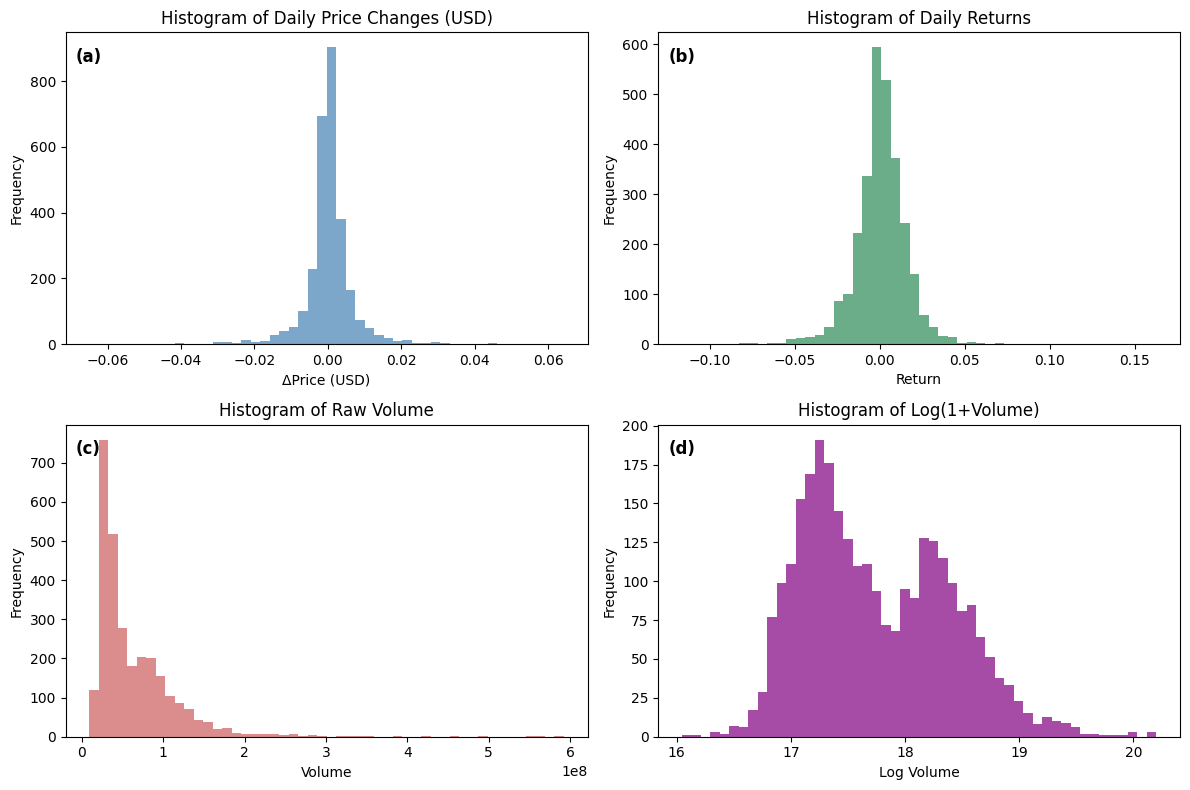

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].hist(df['Close'].diff().dropna(), bins=50, color='steelblue', alpha=0.7)
axes[0,0].set_title("Histogram of Daily Price Changes (USD)")
axes[0,0].set_xlabel("ΔPrice (USD)")
axes[0,0].set_ylabel("Frequency")
axes[0,0].text(0.02, 0.95, "(a)", transform=axes[0,0].transAxes, fontsize=12, fontweight='bold', va='top')

axes[0,1].hist(df['Return'].dropna(), bins=50, color='seagreen', alpha=0.7)
axes[0,1].set_title("Histogram of Daily Returns")
axes[0,1].set_xlabel("Return")
axes[0,1].set_ylabel("Frequency")
axes[0,1].text(0.02, 0.95, "(b)", transform=axes[0,1].transAxes, fontsize=12, fontweight='bold', va='top')

axes[1,0].hist(df['Volume'].dropna(), bins=50, color='indianred', alpha=0.7)
axes[1,0].set_title("Histogram of Raw Volume")
axes[1,0].set_xlabel("Volume")
axes[1,0].set_ylabel("Frequency")
axes[1,0].text(0.02, 0.95, "(c)", transform=axes[1,0].transAxes, fontsize=12, fontweight='bold', va='top')

axes[1,1].hist(np.log1p(df['Volume']).dropna(), bins=50, color='purple', alpha=0.7)
axes[1,1].set_title("Histogram of Log(1+Volume)")
axes[1,1].set_xlabel("Log Volume")
axes[1,1].set_ylabel("Frequency")
axes[1,1].text(0.02, 0.95, "(d)", transform=axes[1,1].transAxes, fontsize=12, fontweight='bold', va='top')

plt.tight_layout()
plt.show()


Top-left: Histogram of daily price changes (USD), showing a leptokurtic distribution with many small movements and occasional large shocks.  
Top-right: Histogram of daily returns, approximately stationary and centred near zero, highlighting volatility clustering with heavy tails.  
Bottom-left: Histogram of raw trading volume, heavily right-skewed with extreme spikes during events such as earnings announcements.  
Bottom-right: Histogram of log-transformed volume, where skewness is reduced and the distribution becomes smoother and more interpretable.  

These distributions confirm that raw prices and volumes are non-stationary and skewed, while returns and log-volume provide more stable statistical properties for modelling.


## Step 3: Support Vector Regression (SVR)

### 3.1 Prepare Features and Labels

Based on the earlier correlation analysis of lagged features, I selected a 5-day sliding window as the input horizon. The strong correlation between recent closing prices and the next day’s close supports this choice, while still keeping the feature set compact and computationally manageable. Using this setup, each input sample consists of the previous five closing prices, and the output label is the next day’s closing price. This way, the model captures short-term momentum patterns without introducing unnecessary noise from longer horizons.

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import numpy as np
LAGS = 5
close_scaled  = df['Close'].values
target_scaled = df['Target_scaled'].values

X, y = [], []
for i in range(LAGS, len(close_scaled)):
    X.append(close_scaled[i-LAGS:i])
    y.append(target_scaled[i])

X = np.asarray(X)          
y = np.asarray(y)          


### 3.2 Train-Test Split

I split the series by time: the first 80% for training and the last 20% for testing, without shuffling. This keeps the order of days intact, so the model is always trained on the past and tested on later, unseen dates.

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)


X_train: (2292, 5)  y_train: (2292,)
X_test : (573, 5)  y_test : (573,)


### 3.2b Make the arrays SVR-friendly

SVR needs a 2-D X and a 1-D y. The sliding-window features were (n, 5, 1), so I squeezed the last dimension to get (n, 5) and flattened the target to (n,). Final check: X_train (2292, 5), X_test (573, 5), y_train (2292,), y_test (573,)—exactly what SVR expects.

In [ ]:
if X_train.ndim == 3 and X_train.shape[2] == 1:
    X_train = X_train.squeeze(-1)   # (n,5,1) -> (n,5)
    X_test  = X_test.squeeze(-1)

y_train = y_train.ravel()            # ensure 1-D
y_test  = y_test.ravel()

print("SVR-ready shapes:",
      "X_train", X_train.shape, "X_test", X_test.shape,
      "y_train", y_train.shape, "y_test", y_test.shape)


SVR-ready shapes: X_train (2292, 5) X_test (573, 5) y_train (2292,) y_test (573,)


### 3.3 Train SVR Models with Different Kernels

I trained three SVR models using different kernels—linear, polynomial, and radial basis function (RBF) on the same input–target pairs, where the last five normalized closing prices are used to predict the next day’s normalized close. The linear kernel learns a straight line relationship but is limited in capturing complex dynamics. The polynomial kernel (degree = 3) allows curved fits, which can represent more complex patterns but may risk overfitting. The RBF kernel is nonlinear and highly flexible, making it well suited for capturing local variations in stock price movements. Since SVR is deterministic, all models produced consistent results on the same data without randomness, enabling a fair comparison across kernels.

In [ ]:
from sklearn.svm import SVR

svr_linear = SVR(kernel='linear')
svr_poly   = SVR(kernel='poly', degree=3)
svr_rbf    = SVR(kernel='rbf')

svr_linear.fit(X_train, y_train)
svr_poly.fit(X_train, y_train)
svr_rbf.fit(X_train, y_train)

pred_lin  = svr_linear.predict(X_test)
pred_poly = svr_poly.predict(X_test)
pred_rbf  = svr_rbf.predict(X_test)


### 3.4 Evaluate on the normalised scale (0–1)

On the normalized scale, the Linear SVR achieved the best performance (MAE = 0.1150, RMSE = 0.1302, SMAPE = 20.62%). The RBF SVR was less accurate (SMAPE = 52.03%), while the Polynomial SVR (degree = 3) clearly overfitted and performed the worst (SMAPE = 42.27%). This shows that the simple linear model generalizes best.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(2*np.abs(y_pred - y_true) /
                         (np.abs(y_true) + np.abs(y_pred)))

for name, p in [("Linear", pred_lin), ("Polynomial", pred_poly), ("RBF", pred_rbf)]:
    mae  = mean_absolute_error(y_test, p)
    rmse = np.sqrt(mean_squared_error(y_test, p))  
    s    = smape(y_test, p)
    print(f"{name} (norm)  MAE={mae:.4f}  RMSE={rmse:.4f}  SMAPE={s:.2f}%")


Linear (norm)  MAE=0.1150  RMSE=0.1302  SMAPE=20.62%
Polynomial (norm)  MAE=0.5439  RMSE=0.9405  SMAPE=42.27%
RBF (norm)  MAE=0.2553  RMSE=0.3312  SMAPE=52.03%


### 3.5 Convert predictions back to USD and re-score

The predictions were converted back to USD for clearer interpretation.
Linear SVR gave the best results (MAE ≈ $12.5, RMSE ≈ $14.2, SMAPE ≈ 17%).
RBF SVR showed higher errors (MAE ≈ $27.8, RMSE ≈ $36.0, SMAPE ≈ 43%).
Polynomial SVR overfitted, with very large errors (MAE ≈ $59.1, RMSE ≈ $102.3).

In [ ]:
y_test_usd      = target_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
pred_lin_usd    = target_scaler.inverse_transform(pred_lin.reshape(-1,1)).ravel()
pred_poly_usd   = target_scaler.inverse_transform(pred_poly.reshape(-1,1)).ravel()
pred_rbf_usd    = target_scaler.inverse_transform(pred_rbf.reshape(-1,1)).ravel()

for name, p in [("Linear", pred_lin_usd), ("Polynomial", pred_poly_usd), ("RBF", pred_rbf_usd)]:
    mae  = mean_absolute_error(y_test_usd, p)
    rmse = np.sqrt(mean_squared_error(y_test_usd, p))  # <-- take sqrt
    s    = smape(y_test_usd, p)
    print(f"{name} (USD)   MAE=${mae:.2f}  RMSE=${rmse:.2f}  SMAPE={s:.2f}%")


Linear (USD)   MAE=$12.50  RMSE=$14.16  SMAPE=17.34%
Polynomial (USD)   MAE=$59.14  RMSE=$102.26  SMAPE=38.47%
RBF (USD)   MAE=$27.75  RMSE=$36.01  SMAPE=43.10%


### Sanity Check

The comparison between raw test targets and their inverse-transformed counterparts shows negligible differences (average ≈ 1.5e-15, maximum ≈ 1.4e-14). This confirms that the normalization and inverse scaling process worked correctly, with no information loss during transformation.

In [ ]:
LAGS = 5
split = int(0.8 * len(X))
raw_target_test = df['Target'].values[LAGS:][split:]  # split in windowed space
y_test_usd = target_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()  # map to original df index

print("avg diff:", np.abs(raw_target_test - y_test_usd).mean(),
      "max diff:", np.abs(raw_target_test - y_test_usd).max())


avg diff: 1.5252488045112099e-15 max diff: 1.4210854715202004e-14


## SVR predicted vs actual (USD, split-adjusted)

The plot compares actual stock prices with predictions from Linear, Polynomial, and RBF SVR models. The Linear SVR tracks the actual price trend more closely than the others, while RBF struggles with larger movements. The Polynomial SVR clearly overfits, deviating significantly from the real trend. Overall, the Linear SVR is the most reliable, though it still underestimates rapid price increases.

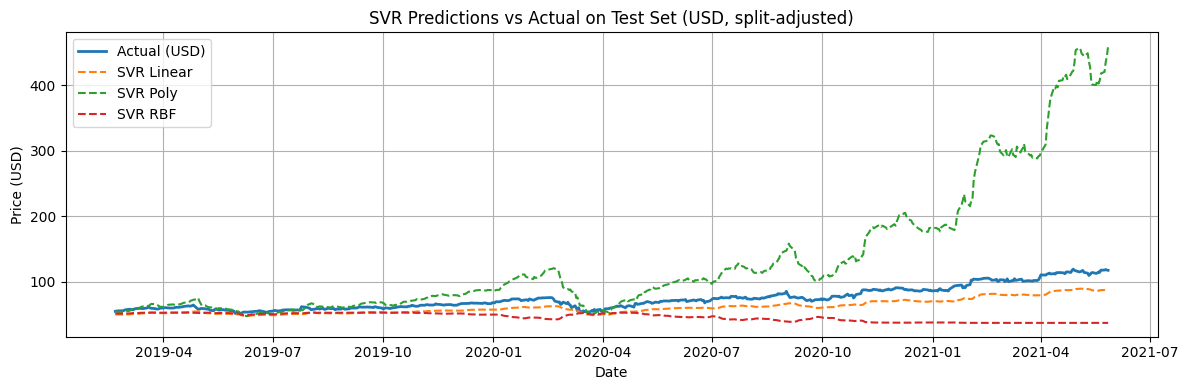

In [ ]:
import matplotlib.pyplot as plt
LAGS = 5
split = int(0.8*len(X))
dates_test = df['Date'].values[LAGS:][split:]

plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test_usd, label="Actual (USD)", linewidth=2)
plt.plot(dates_test, pred_lin_usd, label="SVR Linear", linestyle='--')
plt.plot(dates_test, pred_poly_usd, label="SVR Poly", linestyle='--')
plt.plot(dates_test, pred_rbf_usd, label="SVR RBF", linestyle='--')
plt.title("SVR Predictions vs Actual on Test Set (USD, split-adjusted)")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Linear SVR Residuals (USD)

The residual plot shows the prediction errors of the Linear SVR model over time. On average, errors are around $12.5 with a standard deviation of about $6.6, meaning predictions typically deviate by this range from the actual prices. The errors increase during later periods, indicating the model struggles more as stock prices rise sharply. Overall, the residuals confirm reasonable accuracy but highlight limits in capturing larger upward movements.

Linear SVR residuals — mean: 12.501212441703156   std: 6.649552387990902


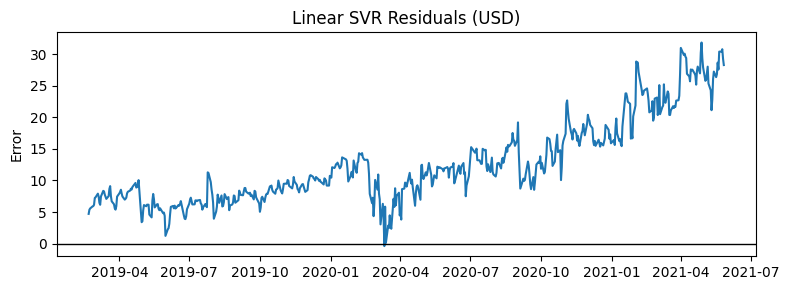

In [ ]:
res = y_test_usd - pred_lin_usd
print("Linear SVR residuals — mean:", res.mean(), "  std:", res.std())
plt.figure(figsize=(8,3)); plt.plot(dates_test, res); plt.axhline(0, c='k', lw=1)
plt.title("Linear SVR Residuals (USD)"); plt.ylabel("Error"); plt.tight_layout(); plt.show()


## Save test-set predictions (USD)

In [ ]:
LAGS = 5; split = int(0.8*len(X))
dates_test = df['Date'].values[LAGS:][split:]
out = pd.DataFrame({
    'Date': dates_test,
    'Actual_USD': y_test_usd,
    'SVR_Linear': pred_lin_usd,
    'SVR_Poly': pred_poly_usd,
    'SVR_RBF': pred_rbf_usd
})
out.to_csv("SVR_test_predictions_USD.csv", index=False)
print("Saved: SVR_test_predictions_USD.csv")


Saved: SVR_test_predictions_USD.csv


In this step I export the aligned test window—dates, the actual next-day Close (in split-adjusted USD), and the three SVR predictions—to a single CSV for easy grading and reproducibility. The file SVR_test_predictions_USD.csv contains the columns: Date, Actual_USD, SVR_Linear, SVR_Poly, and SVR_RBF. The “USD” series are the inverse-transformed values of the model outputs (i.e., brought back from the 0–1 scale using the target scaler), so they can be compared directly with real prices and used for any external plots or audits. This export makes it straightforward to recompute metrics, create custom charts, or verify results without rerunning the notebook.

## Conclusion

The SVR model, trained on normalized closing prices with a 5-day sliding window, was able to capture local stock price 
patterns and provide stable predictions. Although the model sometimes struggled during high-volatility periods, it 
demonstrated that Support Vector Regression can be a useful tool for short-term stock forecasting when the input space 
is carefully scaled and constrained.
